# How to use bikit-models

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.insert(0, os.path.abspath('./models'))

import torch

import utils
from vistranet import build_vistra
from daclnet import build_dacl

## Load an example image

In [2]:
img_path = './assets/image_0000468_crop_0000001.png'

## Use models from daclnet
Each model has a `cat_to_name` dictionary which defines the order of the classes in the output. 

/home/jfltzngr/anaconda3/envs/dacl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jfltzngr/anaconda3/envs/dacl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=====Model summary=====
The model was instantiated from ./models/checkpoints/codebrim-classif-balanced/codebrim-classif-balanced_MobileNetV3-Large_hta.pth with the following arguments:
dataset: codebrim-classif-balanced
base: mobilenet
resolution: 224
run: earnest-durian-22
best_val_loss_cp: 0.23312173125805793
best_val_emr_cp: 0.8607633113861084
best_val_epoch_cp: 44
hidden_layers: [1024]
learning_rate: 1e-05
lr_base: False
scheduler_name: cosine
drop_prob: 0.3
approach: hta
num_class: 6
cat_to_name: {0: 'NoDamage', 1: 'Crack', 2: 'Efflorescence', 3: 'Spalling', 4: 'BarsExposed', 5: 'Rust'}
The base is frozen: True

********** Output **********
NoDamage: 5.47%
Crack: 1.24%
Efflorescence: 0.27%
Spalling: 98.58%
BarsExposed: 96.62%
Rust: 80.03%


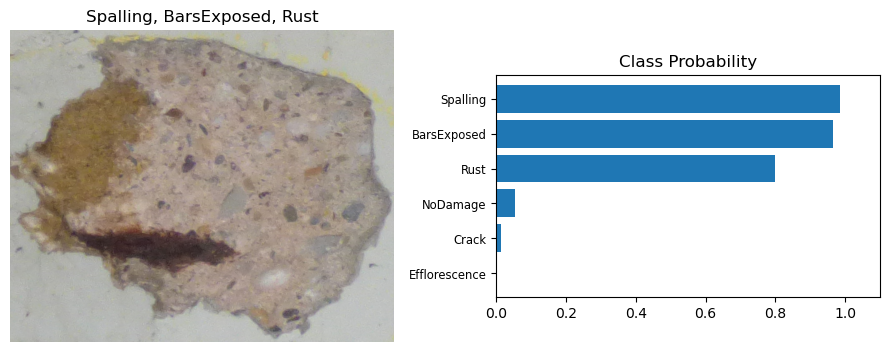

In [3]:
# Preprocess image
img_proc = utils.process_img_daclnet(img_path)

# Instantiate the model:
model, cat_to_name = build_dacl(cp_path= './models/checkpoints/codebrim-classif-balanced/codebrim-classif-balanced_MobileNetV3-Large_hta.pth')

model.eval()
with torch.no_grad(): # Disable tracking of gradients in autograd (saves some time)
    logits = model(img_proc)
    preds = torch.sigmoid(logits).float().squeeze(0)

# Make a dict with the predictions:
preds_dict = {v:round(preds[int(k)].item(),4) for k,v in cat_to_name.items()}
print('*'*10, 'Output', '*'*10)
for k,v in preds_dict.items():
    print('%s: %.2f%%' % (k,v*100)) 
# View the classified image and it's predictions:
utils.view_classify(img_path, preds_dict)

## Use model from SOFIA

/home/jfltzngr/anaconda3/envs/dacl/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


frozen encoder  encoder
vit_small adapter built. 0 trainable params, 21656833 frozen params.
frozen decoder  decoder
decoder adapter built. 0 trainable params, 9222 frozen params.
quantization
=====Model summary=====
The model was instantiated from ./models/checkpoints/codebrim-classif-balanced/codebrim-classif-balanced_ViT_s8.pth and loaded with msg: <All keys matched successfully> with the following arguments:
img_size: 224
num_class: 6
cat_to_name: {0: 'NoDamage', 1: 'Crack', 2: 'Spalling', 3: 'Efflorescence', 4: 'BarsExposed', 5: 'Rust'}
dataset: codebrim-classif-balanced

********** Output **********
NoDamage: 0.04%
Crack: 0.01%
Spalling: 99.94%
Efflorescence: 0.02%
BarsExposed: 97.42%
Rust: 43.20%


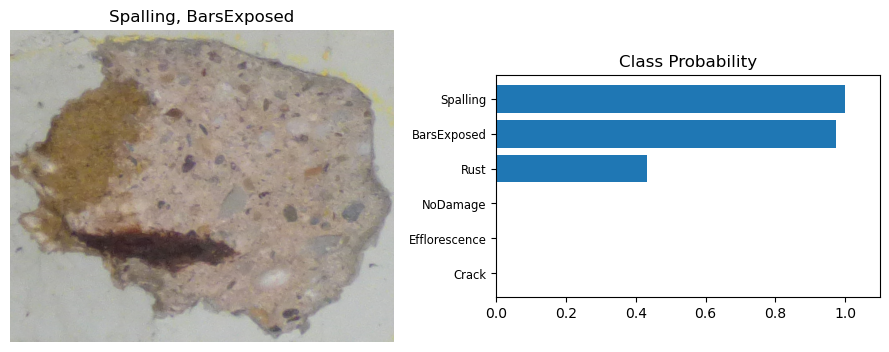

In [4]:
# Preprocess image
img_proc = utils.process_img_vistranet(img_path)

# Instantiate the model:
model, cat_to_name = build_vistra(cp_path='./models/checkpoints/codebrim-classif-balanced/codebrim-classif-balanced_ViT_s8_0.pth')

model.eval()
with torch.no_grad(): # Disable tracking of gradients in autograd (saves some time)
    logits = model(img_proc)
    preds = torch.sigmoid(logits).float().squeeze(0)

# Make a dict with the predictions:
preds_dict = {v:round(preds[int(k)].item(),4) for k,v in cat_to_name.items()}
print('*'*10, 'Output', '*'*10)
for k,v in preds_dict.items():
    print('%s: %.2f%%' % (k,v*100)) 
# View the classified image and it's predictions:
utils.view_classify(img_path, preds_dict)

## Use a PyTorch model from daclnet which was converted to TorchScript by tracing
The models are located at: `./models/jit_models/*/*.pt`.
There are no TorchScript models for EfficientNetV1-B0 due to the following Error when trying to convert it:
```
RuntimeError: 
Could not export Python function call 'SwishImplementation'. Remove calls to Python functions before export. Did you forget to add @script or @script_method annotation? If this is a nn.ModuleList, add it to __constants__:
```

********** Output **********
NoDamage: 5.47%
Crack: 1.24%
Efflorescence: 0.27%
Spalling: 98.58%
BarsExposed: 96.62%
Rust: 80.03%


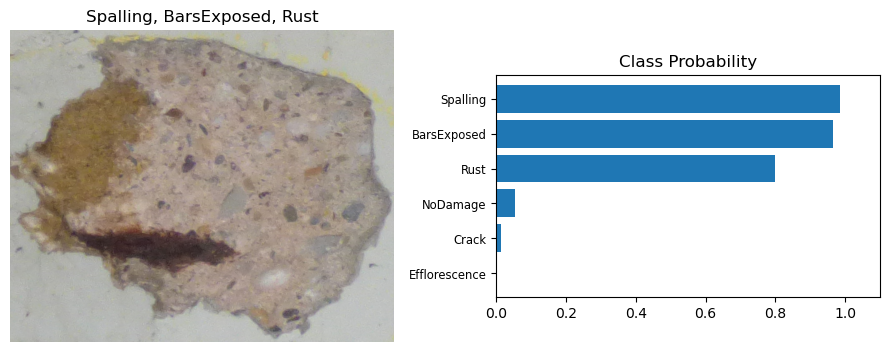

In [5]:
# Preprocess image
img_proc = utils.process_img_daclnet(img_path) # Make sure to use the preprocessing according to the 
                                               # original submission (If results shall be reproduced)

model = torch.jit.load('./models/jit_models/codebrim-classif-balanced/codebrim-classif-balanced_MobileNetV3-Large_hta.pt')
model.eval()

with torch.no_grad(): # Disable tracking of gradients in autograd (saves some time)
    logits = model(img_proc)
    preds = torch.sigmoid(logits).float().squeeze(0)

# We couldn't save the 'cat_to_name'-dict in the TorchScript so we have to define it ourselves:
cat_to_name = {0: 'NoDamage', 1: 'Crack', 2: 'Efflorescence', 3: 'Spalling', 4: 'BarsExposed', 5: 'Rust'}

# Make a dict with the predictions:
preds_dict = {v:round(preds[int(k)].item(),4) for k,v in cat_to_name.items()}
print('*'*10, 'Output', '*'*10)
for k,v in preds_dict.items():
    print('%s: %.2f%%' % (k,v*100)) 
# View the classified image and it's predictions:
utils.view_classify(img_path, preds_dict)

## Use a PyTorch model from SOFIA which was converted to TorchScript by tracing
The models are located at: `./models/jit_models/*.pt`

********** Output **********
NoDamage: 0.04%
Crack: 0.01%
Spalling: 99.94%
Efflorescence: 0.02%
BarsExposed: 97.42%
Rust: 43.20%


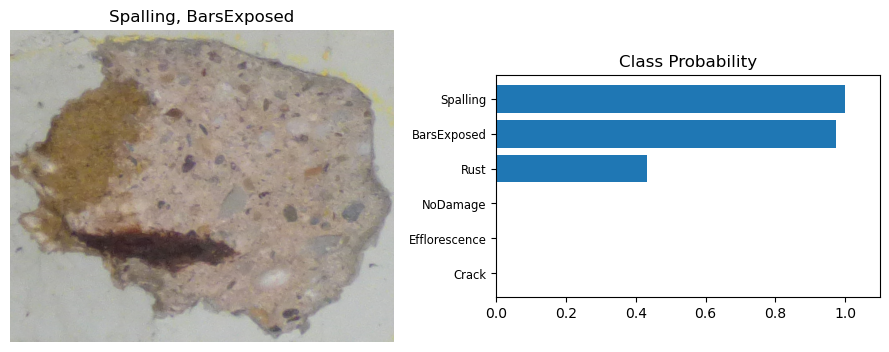

In [6]:
# Preprocess image
img_proc = utils.process_img_vistranet(img_path) # Make sure to use the preprocessing according to the 
                                               # original submission (If results shall be reproduced)

model = torch.jit.load('./models/jit_models/codebrim-classif-balanced/codebrim-classif-balanced_ViT_s8_0.pt')
model.eval()

with torch.no_grad(): # Disable tracking of gradients in autograd (saves some time)
    logits = model(img_proc)
    preds = torch.sigmoid(logits).float().squeeze(0)

# We couldn't save the 'cat_to_name'-dict in the TorchScript so we have to define it ourselves:
cat_to_name = {0: 'NoDamage', 1: 'Crack', 2: 'Spalling', 3: 'Efflorescence', 4: 'BarsExposed', 5: 'Rust'}

# Make a dict with the predictions:
preds_dict = {v:round(preds[int(k)].item(),4) for k,v in cat_to_name.items()}
print('*'*10, 'Output', '*'*10)
for k,v in preds_dict.items():
    print('%s: %.2f%%' % (k,v*100)) 
# View the classified image and it's predictions:
utils.view_classify(img_path, preds_dict)